# Problem description

Five times more deadly than the flu, COVID-19 causes significant morbidity and mortality. Like other pneumonias, pulmonary infection with COVID-19 results in inflammation and fluid in the lungs. COVID-19 looks very similar to other viral and bacterial pneumonias on chest radiographs, which makes it difficult to diagnose. This computer vision model for detection and localization of COVID-19 would help doctors provide a quick and confident diagnosis. As a result, patients could get the right treatment before the most severe effects of the virus take hold.


Currently, COVID-19 can be diagnosed via polymerase chain reaction to detect genetic material from the virus or chest radiograph. However, it can take a few hours and sometimes days before the molecular test results are back. By contrast, chest radiographs can be obtained in minutes. While guidelines exist to help radiologists differentiate COVID-19 from other types of infection, their assessments vary. In addition, non-radiologists could be supported with better localization of the disease, such as with a visual bounding box.


In this competition, the task is to identify and localize COVID-19 abnormalities on chest radiographs. In particular, categorization of the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19.

* train_study_level.csv - the train study-level metadata, with one row for each study, including correct labels.
* train_image_level.csv - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
* sample_submission.csv - a sample submission file containing all image- and study-level IDs.
* train folder - comprises 6334 chest scans in DICOM format, stored in paths with the form study/series/image
* test folder - The hidden test dataset is of roughly the same scale as the training dataset. Studies in the test set may contain more than one label.

# Content table

1. Importing the libraries
2. Importing the datasets
3. Data exploration
4. Read Dicom files
5. Feature engineering
6. Credits

# Importing the libraries

In [90]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pydicom as dicom # Dicom (Digital Imaging in Medicine) - medical image datasets, storage and transfer
import os
from tqdm import tqdm # allows you to output a smart progress bar by wrapping around any iterable
import glob # retrieve files/pathnames matching a specified pattern
import pprint # pretty-print” arbitrary Python data structures
import ast # 

# Importing the datasets

In [91]:
path = '/kaggle/input/siim-covid19-detection/'
train_image_level = pd.read_csv(path + "train_image_level.csv")
train_study_level = pd.read_csv(path + "train_study_level.csv")

# Data exploration

Let's have a look inside the train_image_level.

In [92]:
train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [93]:
train_image_level.describe()

,id,boxes,label,StudyInstanceUID
count,6334,4294,6334,6334
unique,6334,4294,4295,6054
top,73b1deca7a38_image,"[{'x': 324.61439, 'y': 333.75474, 'width': 529...",none 1 0 0 1 1,0fd2db233deb
freq,1,1,2040,9


There are 6334 unique values in the train_image_level dataframe.

In [94]:
train_study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [95]:
train_study_level.describe()

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
count,6054.000000,6054.000000,6054.000000,6054.000000
mean,0.276842,0.471589,0.173274,0.078295
std,0.447475,0.499233,0.378515,0.268658
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


There are 6054 rows in the train_study_level dataframe. The number of unique values in study dataframe differs from the unique values in the images dataframe. Let's check how many studies have more than 1 image linked.

In [96]:
train_study_level_key = train_study_level.id.str[:-6]
training_set = pd.merge(left = train_study_level, right = train_image_level, how = 'right', left_on = train_study_level_key, right_on = 'StudyInstanceUID')
training_set.drop(['id_x'], axis = 1)

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_y,boxes,label,StudyInstanceUID
0,0,1,0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,1,0,0,0,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0,1,0,0,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,0,0,0,1,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,0,1,0,0,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...,...,...,...,...
6329,1,0,0,0,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,1,0,0,0,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,0,1,0,0,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,0,1,0,0,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


Let's have a look at these studies with multiple images:

In [97]:
training_set[training_set.groupby('StudyInstanceUID')['id_y'].transform('size') > 1].sort_values('StudyInstanceUID')

,id_x,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_y,boxes,label,StudyInstanceUID
2862,00f9e183938e_study,0,0,0,1,74077a8e3b7c_image,"[{'x': 2175.24285, 'y': 1123.72368, 'width': 4...",opacity 1 2175.24285 1123.72368 2607.50603 162...,00f9e183938e
2490,00f9e183938e_study,0,0,0,1,6534a837497d_image,NaN,none 1 0 0 1 1,00f9e183938e
2119,0142feaef82f_study,0,0,1,0,55e22c0c5de0_image,"[{'x': 455.99999, 'y': 1480.00008, 'width': 26...",opacity 1 455.99999 1480.00008 722.39998 2437....,0142feaef82f
6061,0142feaef82f_study,0,0,1,0,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f
3880,0369e0385796_study,0,1,0,0,9e4824fcee2e_image,"[{'x': 817.77961, 'y': 1075.34501, 'width': 64...",opacity 1 817.77961 1075.34501 1467.08961 2075...,0369e0385796
...,...,...,...,...,...,...,...,...,...
1600,fc45007f145a_study,0,1,0,0,4123a71d9796_image,"[{'x': 889.45144, 'y': 282.39441, 'width': 825...",opacity 1 889.45144 282.39441 1714.51125 1585....,fc45007f145a
827,fd92c6f2b2e6_study,1,0,0,0,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6
5735,fd92c6f2b2e6_study,1,0,0,0,e6cc65d9de1d_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6
3277,ffcb4630f46f_study,0,1,0,0,84ed5f7f71bf_image,"[{'x': 1721.27651, 'y': 974.09667, 'width': 12...",opacity 1 1721.27651 974.09667 2999.21998 2681...,ffcb4630f46f


# Read Dicom files

Function used to locate image from the path:

In [98]:
def extract_image(i):
    path_train = path + 'train/' + training_set.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = training_set.loc[i, 'id_y'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train + img_id)
    img = data_file.pixel_array
    return img

Images and rectangles visualization

000a312787f2.dcm
000c3a3f293f.dcm
0012ff7358bc.dcm
001398f4ff4f.dcm
001bd15d1891.dcm
0022227f5adf.dcm
0023f02ae886.dcm
002e9b2128d0.dcm
00326161e51e.dcm


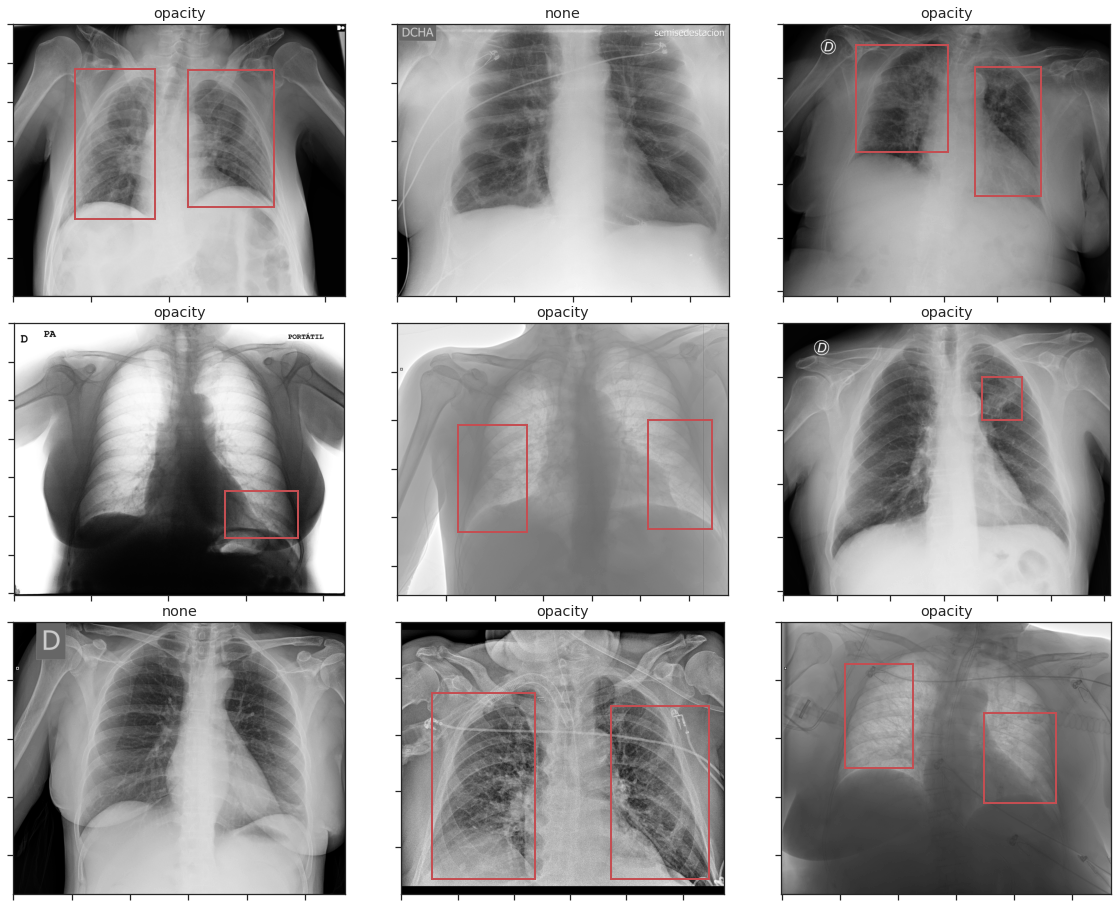

In [99]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

for row in range(9):
    img = extract_image(row)
    if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
        boxes = ast.literal_eval(training_set.loc[row,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec='r', fc='none', lw=2.
                                            )
            axes[row].add_patch(p)
    axes[row].imshow(img, cmap='gray')
    axes[row].set_title(training_set.loc[row, 'label'].split(' ')[0])
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

# Feature engineering

Count the number of opacities in the image

In [100]:
Opacity_Count = training_set['label'].str.count('opacity')
training_set['Opacity_Count'] = Opacity_Count.values

Sum of areas of rectangles - assumption : the bigger the rectangle - the bigger the opacity

In [101]:
image_rectangles_areas = []

for row in range(6334):#len(training_set.index)):
    image_rectangles_area_sum = 0
    rectangle_area = 0
    if (training_set.loc[row,'boxes'] == training_set.loc[row,'boxes']):
        boxes = ast.literal_eval(training_set.loc[row,'boxes'])
        for box in boxes:
            rectangle_area = box['width'] * box['height']
            #print('Rectangle area : {} '.format(rectangle_area))
            image_rectangles_area_sum = image_rectangles_area_sum + rectangle_area
            #training_set['Image_Rectangles_Area_Sum'] = 
        image_rectangles_areas.append(image_rectangles_area_sum)
    else:
        image_rectangles_area_sum = image_rectangles_area_sum + rectangle_area
        image_rectangles_areas.append(image_rectangles_area_sum)
        

In [102]:
training_set['Rectangle_Area'] = image_rectangles_areas

Creating buckets - rectangle areas

First see the distribution of the rectangle areas

In [103]:
training_set['Rectangle_Area'] = round(training_set['Rectangle_Area'],2)

In [104]:
training_set['Rectangle_Area']

0       3896712.30
1             0.00
2       1610730.42
3        572592.07
4       1531870.67
           ...    
6329          0.00
6330          0.00
6331     557726.58
6332    4410887.70
6333     517602.10
Name: Rectangle_Area, Length: 6334, dtype: float64

In [105]:
#pd.qcut(training_set['Rectangle_Area'], q = 4)

#training_set.boxplot(by = "Negative for Pneumonia",column = ['Rectangle_Area'],grid = True, layout=(1, 1))

cut_labels_4 = ['0', '<1e6', '<2e6', '<4e6', '<8e6']
cut_bins = [-1, 0, 1000000, 2000000, 4000000, 8000000]
training_set['Rectangle_Area_Bin'] = pd.cut(training_set['Rectangle_Area'], bins=cut_bins, labels=cut_labels_4)

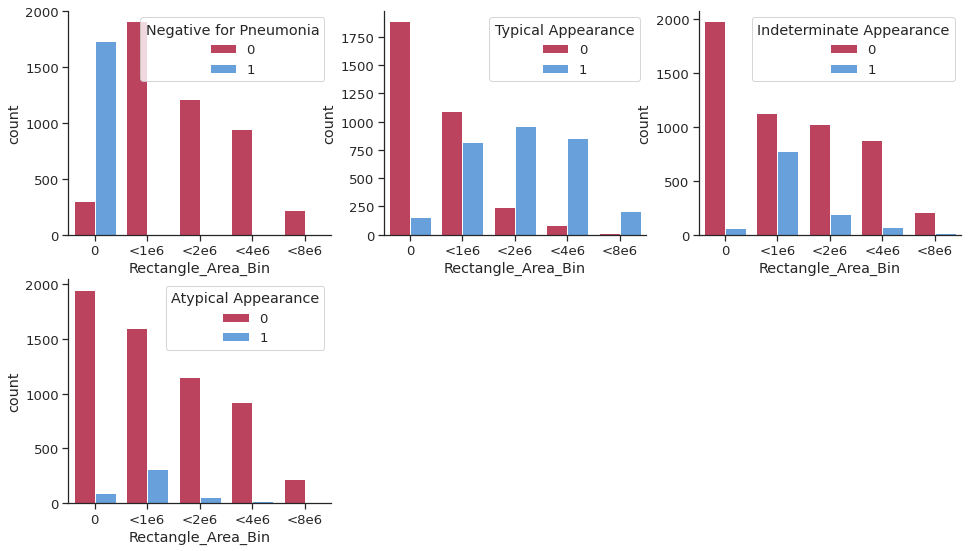

In [106]:
columns = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

plt.figure(figsize = (16, 14))
sn.set(font_scale = 1.2)
sn.set_style('ticks')

for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    sn.countplot(data = training_set, x = 'Rectangle_Area_Bin', hue = column, palette = ['#d02f52',"#55a0ee"])
    
sn.despine()

Rectangle area and opacity count

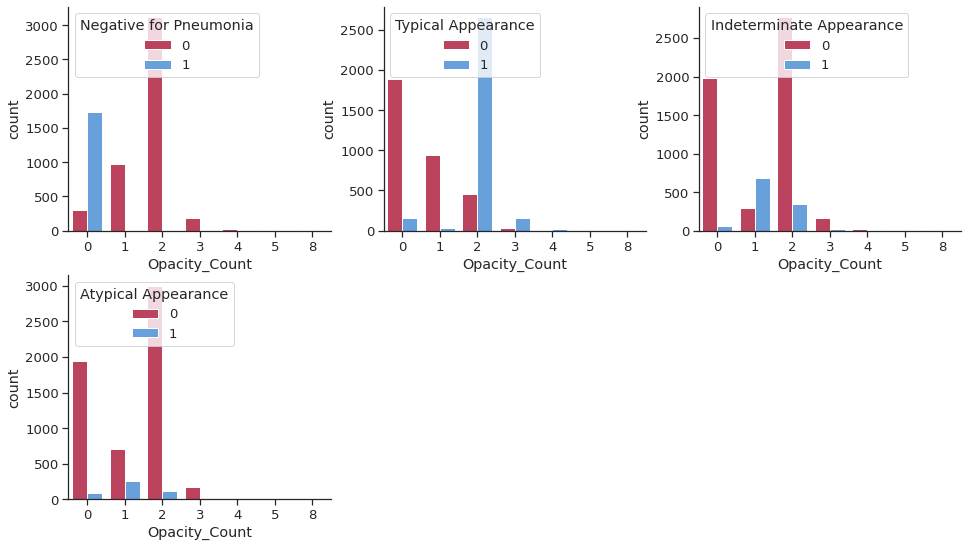

In [107]:
columns = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

plt.figure(figsize = (16, 14))
sn.set(font_scale = 1.2)
sn.set_style('ticks')

for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    sn.countplot(data = training_set, x = 'Opacity_Count', hue = column, palette = ['#d02f52',"#55a0ee"])
    
sn.despine()

AttributeError: 'str' object has no attribute 'values'

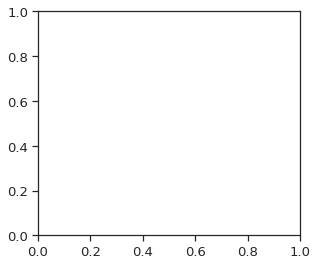

In [112]:
columns = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
opacity = training_set['Opacity_Count'].unique()

plt.figure(figsize = (16, 14))
sn.set(font_scale = 1.2)
sn.set_style('ticks')

for j in opacity:
    for i, column in enumerate(columns):
        plt.subplot(3, 3, i + 1)
        sn.barplot(data = training_set, x = column, y = training_set['Opacity_Count']/sum(training_set['Opacity_Count'] == j), palette = ['#d02f52',"#55a0ee"])
    
sn.despine()

Position of the rectangle by quadrants (4 bins - 4 quadrants)

Image metadata information - unique

# Credits

* https://github.com/pydicom/pydicom/issues/319